In [1]:
import sys
sys.path.append("/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/_scripts")

from typing import Union
from dataclasses import dataclass

from copy import deepcopy
import json

from case_edits.ezcase import EzCase

from recipes.amber import input
from recipes.exp_01 import input as input1, ns_axis
from geometry.wall_normal import WallNormal
from helpers.helpers import key_from_value
from methods.subsurfaces.pairs import DEFAULT_WINDOW, SubsurfacePair, DEFAULT_DOOR
from helpers.shapely_helpers import get_point_as_xy


from gplan.subsurface_translator import SubsurfaceTranslator

from helpers.plots import *

import shapely as sp

In [2]:
ez = EzCase(input, RUN_CASE=False)
ez.create_case()

tests/test21_amber


In [3]:
ez.add_rooms()

00
Added 5 walls 
01
Added 4 walls 
02
Added 4 walls 
03
Added 6 walls 
04
Added 4 walls 
05
Added 5 walls 
06
Added 7 walls 
07
Added 6 walls 
08
Added 4 walls 
09
Added 5 walls 
010
Added 5 walls 


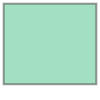

In [6]:
ez.case.geometry.zones["B_00"].polygon

In [4]:
c = ez.gplan_convert.blocks[8]["coordinates"]
c

[(10.71, 0.0), (10.71, 2.61), (8.58, 2.61), (8.58, 0.0)]

In [5]:
[(float(i[0]), float(i[1])) for i in c][0][0]

10.71

In [6]:
surfs = ez.case.idf.idfobjects["BUILDINGSURFACE:DETAILED"]
surfs


[
BUILDINGSURFACE:DETAILED,
    Block 00 Storey 0 Wall 0002,    !- Name
    wall,                     !- Surface Type
    Project Wall,             !- Construction Name
    Block 00 Storey 0,        !- Zone Name
    ,                         !- Space Name
    outdoors,                 !- Outside Boundary Condition
    ,                         !- Outside Boundary Condition Object
    SunExposed,               !- Sun Exposure
    WindExposed,              !- Wind Exposure
    autocalculate,            !- View Factor to Ground
    autocalculate,            !- Number of Vertices
    3.22,                     !- Vertex 1 Xcoordinate
    5.95,                     !- Vertex 1 Ycoordinate
    10,                       !- Vertex 1 Zcoordinate
    3.22,                     !- Vertex 2 Xcoordinate
    5.95,                     !- Vertex 2 Ycoordinate
    0,                        !- Vertex 2 Zcoordinate
    0,                        !- Vertex 3 Xcoordinate
    5.95,                     !- Vertex

In [7]:
[j] = [i for i in surfs if i.Name in "Block 07 Storey 0 Wall 0002_1"]
j



BUILDINGSURFACE:DETAILED,
    Block 07 Storey 0 Wall 0002_1,    !- Name
    wall,                     !- Surface Type
    Project Partition,        !- Construction Name
    Block 07 Storey 0,        !- Zone Name
    ,                         !- Space Name
    surface,                  !- Outside Boundary Condition
    Block 010 Storey 0 Wall 0004_1,    !- Outside Boundary Condition Object
    NoSun,                    !- Sun Exposure
    NoWind,                   !- Wind Exposure
    autocalculate,            !- View Factor to Ground
    autocalculate,            !- Number of Vertices
    5.019999999552965,        !- Vertex 1 Xcoordinate
    4.2,                      !- Vertex 1 Ycoordinate
    10,                       !- Vertex 1 Zcoordinate
    5.019999999552965,        !- Vertex 2 Xcoordinate
    4.2,                      !- Vertex 2 Ycoordinate
    0,                        !- Vertex 2 Zcoordinate
    3.2199999997392297,       !- Vertex 3 Xcoordinate
    4.2,                     

In [8]:
round(j.Vertex_4_Xcoordinate, 2)

3.22

In [9]:
ld = {v.bunch_name:v.line for i,v in ez.case.geometry.zones["B_08"].walls.items()}
ld

{'B_08_East_W01': <LINESTRING (10.71 0, 10.71 2.61)>,
 'B_08_South_W04': <LINESTRING (8.58 0, 10.71 0)>,
 'B_08_North_W02_1': <LINESTRING (10.71 2.61, 8.58 2.61)>,
 'B_08_West_W03_1': <LINESTRING (8.58 2.61, 8.58 0)>}

In [31]:
[i.line for i in ez.case.geometry.zones["B_08"].wall_list]

[<LINESTRING (10.71 0, 10.71 2.61)>,
 <LINESTRING (8.58 0, 10.71 0)>,
 <LINESTRING (10.71 2.61, 8.58 2.61)>,
 <LINESTRING (8.58 2.61, 8.58 0)>]

In [5]:
ez.case.geometry.zones

Munch({})

In [25]:
ldd = list(ld.values())
ldd[2].xy

(array('d', [10.709999999962747, 8.579999999608845]), array('d', [2.61, 2.61]))

In [28]:
sp.snap(ldd[2], ldd[0], 0.1).xy

(array('d', [10.71, 8.579999999608845]), array('d', [2.61, 2.61]))

In [17]:
p = sp.convex_hull(sp.union_all(list(ld.values())))
[c for c in p.exterior.coords]

[(8.58, 0.0),
 (8.579999999608845, 2.61),
 (10.71, 2.61),
 (10.71, 0.0),
 (8.58, 0.0)]

In [20]:
p1 = sp.simplify(p, tolerance=0.01)
[c for c in p1.exterior.coords]

[(8.58, 0.0),
 (8.579999999608845, 2.61),
 (10.71, 2.61),
 (10.71, 0.0),
 (8.58, 0.0)]

In [9]:
pts = [get_point_as_xy(v.line.centroid) for v in ez.case.geometry.zones["B_08"].walls.values()]
pts

[(10.71, 1.305),
 (9.645, 0.0),
 (9.644999999785796, 2.61),
 (8.58, 1.3049999999348074)]

In [8]:
td = {i: prepare_line_traces(v, color="blue", label=i) for i,v in ld.items()}

fig = go.Figure()
for trace in td.values():
    fig.add_trace(trace)

fig.show()

In [74]:
import math
def sort_counterclockwise(points, lines, centre = None):
  if centre:
    centre_x, centre_y = centre
  else:
    centre_x, centre_y = sum([x for x,_ in points])/len(points), sum([y for _,y in points])/len(points)
  angles = [math.atan2(y - centre_y, x - centre_x) for x,y in points]
  counterclockwise_indices = sorted(range(len(points)), key=lambda i: angles[i])
  counterclockwise_points = [points[i] for i in counterclockwise_indices]
  ccw_lines = [lines[i] for i in counterclockwise_indices]
  return counterclockwise_points, ccw_lines

In [78]:
pts = [get_point_as_xy(v.line.centroid) for v in ez.case.geometry.zones["B_010"].walls.values()]
lines = [(k,v.line) for k, v in ez.case.geometry.zones["B_010"].walls.items()]




_, nl = sort_counterclockwise(pts, lines)

In [82]:
nl

[('B_010_South_W04_1', <LINESTRING (3.22 4.2, 5.02 4.2)>),
 ('B_010_East_W01_2', <LINESTRING (5.02 4.2, 5.02 4.65)>),
 ('B_010_East_W01_1', <LINESTRING (5.02 4.65, 5.02 5.95)>),
 ('B_010_North_W02', <LINESTRING (5.02 5.95, 3.22 5.95)>),
 ('B_010_West_W03_1', <LINESTRING (3.22 5.95, 3.22 4.2)>)]

In [81]:
td = {i[0]: prepare_line_traces(i[1], color="blue", label=i[0]) for i in nl}

fig = go.Figure()
for trace in td.values():
    fig.add_trace(trace)

fig.show()

In [83]:
just_lines = [i[1] for i in nl]
just_lines

[<LINESTRING (3.22 4.2, 5.02 4.2)>,
 <LINESTRING (5.02 4.2, 5.02 4.65)>,
 <LINESTRING (5.02 4.65, 5.02 5.95)>,
 <LINESTRING (5.02 5.95, 3.22 5.95)>,
 <LINESTRING (3.22 5.95, 3.22 4.2)>]

In [92]:
[c for c in just_lines[0].coords]

[(3.2199999997392297, 4.2), (5.019999999552965, 4.2)]

In [89]:
[g for g in sp.unary_union(just_lines).geoms]

[<LINESTRING (3.22 4.2, 3.22 4.2)>,
 <LINESTRING (3.22 4.2, 5.02 4.2)>,
 <LINESTRING (5.02 4.2, 5.02 4.65)>,
 <LINESTRING (5.02 4.65, 5.02 5.95)>,
 <LINESTRING (5.02 5.95, 3.22 5.95)>,
 <LINESTRING (3.22 5.95, 3.22 4.2)>,
 <LINESTRING (3.22 4.2, 3.22 4.2)>]

In [84]:
sp.polygonize(just_lines)

In [72]:
a = (0,0)
b = (2,0)
c = (1,1)
lines = [sp.LineString([a,b]), sp.LineString([b,c]), sp.LineString([c,a])]
lines

[<LINESTRING (0 0, 2 0)>, <LINESTRING (2 0, 1 1)>, <LINESTRING (1 1, 0 0)>]

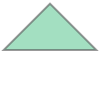

In [73]:
sp.polygonize(lines)